In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sklearn.cluster
import re
import spacy
import matplotlib
from matplotlib import pyplot as plt

In [4]:
articles = pd.read_excel('/Users/clairefenton/Downloads/ATL_predictions_1941.xlsx')
nyt = pd.read_excel('/Users/clairefenton/Downloads/NYT_predictions.xlsx')
atl70 = pd.read_excel('/Users/clairefenton/Desktop/Emory/ATL_1970_Predictions_new_preprocessing.xlsx')

In [5]:
articles['original_text'] = articles['original_text'].apply(lambda x : x[0:x.index('Â\xa0')])

In [6]:
articles['original_text'].str.strip()

0                                  "HONEYMOON PREFERRED"
1                 POLICEMEN KEPT BUSY AS 1940 PASSES OUT
2                                  "HONEYMOON PREFERRED"
3      SLAYER FREED WITHOUT BAIL IN PRELIMINARY HEARI...
4               Man Believed Insane Picks Jail Cell Lock
                             ...                        
773        Xmas Cheer Chairman Is Abused By Liquor Squad
774          Four Victims, Of Nobs In '41, Says Tuskegee
775                        MANILA SUFFERS NEW JAP BLASTS
776                      Rice Disloyalty Rumor Is Spiked
777                 Friction With MP's Again In Columbia
Name: original_text, Length: 778, dtype: object

In [7]:
articles = articles.iloc[:, [4, 6, 7, 13]]

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
sent_vecs = {}
docs = []

for title in tqdm(articles.original_text):
    doc = nlp(title)
    docs.append(doc)
    sent_vecs.update({title: doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

100%|██████████| 778/778 [00:08<00:00, 90.87it/s] 


In [10]:
x = np.array(vectors)

n_classes = {}

for i in tqdm(np.arange(0.001, 1, 0.002)):
    dbscan = sklearn.cluster.DBSCAN(eps=i, min_samples=2, metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

dbscan = sklearn.cluster.DBSCAN(eps=0.08, min_samples=2, metric='cosine').fit(x)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 74.82it/s] 


For looking at an individual cluster

In [11]:
results = pd.DataFrame({'label': dbscan.labels_, 'sent': sentences})
example_result = results[results.label == 0].sent.tolist()
event_df = articles[articles.original_text.isin(example_result)][['AlphaPubDate', 'original_text', 'entry']]
event_df['AlphaPubDate'] = pd.to_datetime(event_df.AlphaPubDate)
event_df = event_df.sort_values(by='AlphaPubDate').dropna()

In [12]:
results['entry'] = articles.entry
results['sent'] = results['sent'].str.strip()

In [13]:
results[results.label == 2][['sent', 'entry']]

,sent,entry
12,PRIVATE TUTOR OF SPANISH FOR ATLANTANS,0
28,VIOLENCE FLARES IN TUSKEGEE FOOD STRIKE,0
40,FIREMAN IS FOUND GUILTY IN JUNE SLAYING,1
51,THIRTEEN YEAR OLD GIRL VICTIM OF BRUTALITY,0
100,CHICAGO WARD BOSS IS NAMED IN GRAFT TRIAL,0
111,REPORT PROGRESS IN CRUSADE FOR DEFENSE JOBS,0
113,CHARLIE MOORE INDICTED IN TWO ROBBERIES,0
143,INSURE NEGRO EMPLOYMENT IN DEFENSE HOUSING,0
161,FRACAS ENDS IN STABBING,0
174,EXPECT AGREEMENT IN NEW YORK BUS STRIKE,0


In [14]:
results.label.unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [15]:
results.label.value_counts()

label
-1     556
 2      24
 0      10
 13      7
 9       7
 29      3
 27      3
 7       3
 11      3
 12      3
 30      3
 15      3
 18      3
 28      2
 26      2
 21      2
 25      2
 24      2
 31      2
 23      2
 22      2
 16      2
 20      2
 19      2
 17      2
 14      2
 10      2
 8       2
 6       2
 5       2
 4       2
 3       2
 1       2
 32      2
Name: count, dtype: int64

Convert into events

In [16]:
def get_mean_vector(sents):
    a = np.zeros(300)
    for sent in sents:
        a = a + nlp(sent).vector
    return a/len(sents)

def get_central_vector(sents):
    vecs = []
    for sent in sents:
        doc = nlp(title)
        vecs.append(doc.vector)
    mean_vec = get_mean_vector(sents)
    index = sklearn.metrics.pairwise_distances_argmin_min(np.array([mean_vec]), vecs)[0][0]
    return sents[index]

In [17]:
get_central_vector(sentences)

'Rice Disloyalty Rumor Is Spiked                                                       '

Trying some SVO extraction

In [18]:
articles = pd.read_excel('/Users/clairefenton/Downloads/ATL_predictions_1941.xlsx')

In [19]:
articles.violence = articles[articles['entry'] == 1]

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50948/4052106130.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  articles.violence = articles[articles['entry'] == 1]


In [20]:
articles.violence['title'] = articles.violence['original_text'].apply(lambda x : x[0:x.index('Â\xa0')])

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50948/3706715080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles.violence['title'] = articles.violence['original_text'].apply(lambda x : x[0:x.index('Â\xa0')])


In [21]:
articles.violence['original_text'] = articles.violence['original_text'].apply(lambda x : x.replace('Â\xa0', ''))

/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_50948/3589215945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles.violence['original_text'] = articles.violence['original_text'].apply(lambda x : x.replace('Â\xa0', ''))


In [22]:
input_string = articles.violence['original_text'].iloc[2]
split_parts = re.split(r'\s{2,}', input_string)

In [23]:
nlp = spacy.load("en_core_web_sm")

In [24]:
OBJECT_DEPS = {"dobj", "dative", "attr", "oprd"}
SUBJECT_DEPS = {"nsubj", "nsubjpass", "csubj", "agent", "expl"}

In [25]:
def extract_svo(doc, sub, at, ve):
    for token in doc:
        # is this a verb?
        if token.pos_ == "VERB":
            ve.append(token.text)
        # is this the object?
        if token.dep_ in OBJECT_DEPS or token.head.dep_ in OBJECT_DEPS:
            at.append(token.text)
        # is this the subject?
        if token.dep_ in SUBJECT_DEPS or token.head.dep_ in SUBJECT_DEPS:
            sub.append(token.text)
    #return " ".join(sub).strip().lower(), " ".join(ve).strip().lower(), " ".join(at).strip().lower()

Officially trying to read in all via a function

In [26]:
sub = []
at = []
ve = []
for i in range(len(articles.violence)):
    doc = nlp(articles.violence['text'].iloc[i])
    extract_svo(doc, sub, at, ve)

Subjects (actors)

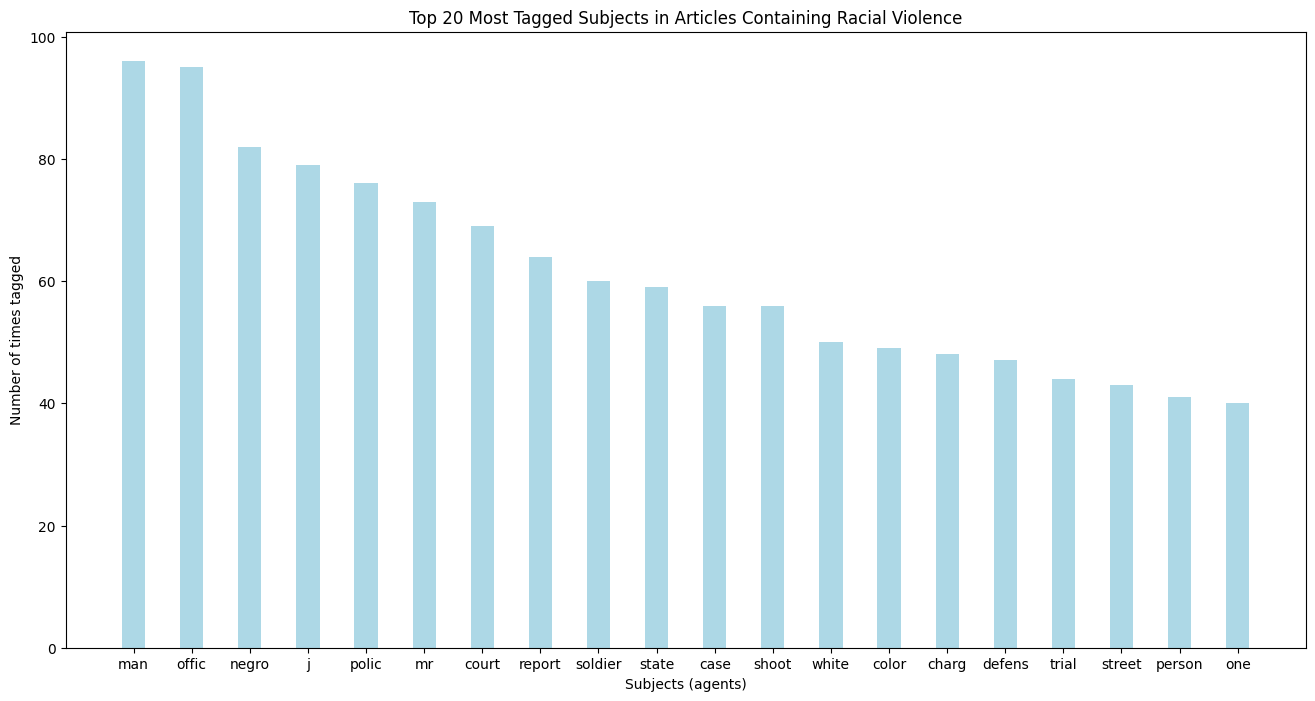

In [27]:
top_20_subjects = pd.Series(sub).value_counts().head(20)
values = top_20_subjects.values
words = top_20_subjects.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='lightblue',
		width = 0.4)

plt.xlabel("Subjects (agents)")
plt.ylabel("Number of times tagged")
plt.title("Top 20 Most Tagged Subjects in Articles Containing Racial Violence")
plt.show()

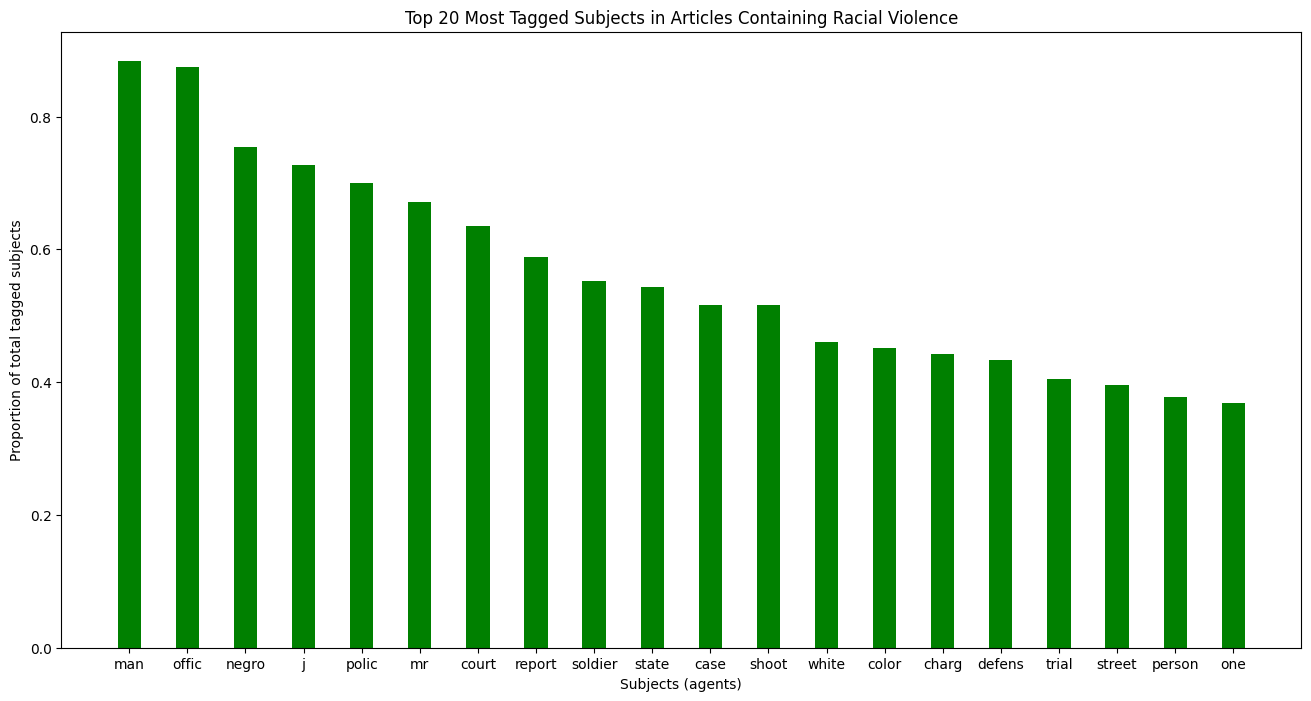

In [28]:
top_20_subjects_prop = (pd.Series(sub).value_counts().head(20)/sum(pd.Series(sub).value_counts().values)) * 100
values = top_20_subjects_prop.values
words = top_20_subjects_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='green',
		width = 0.4)

plt.xlabel("Subjects (agents)")
plt.ylabel("Proportion of total tagged subjects")
plt.title("Top 20 Most Tagged Subjects in Articles Containing Racial Violence")
plt.show()

Objects (victims)

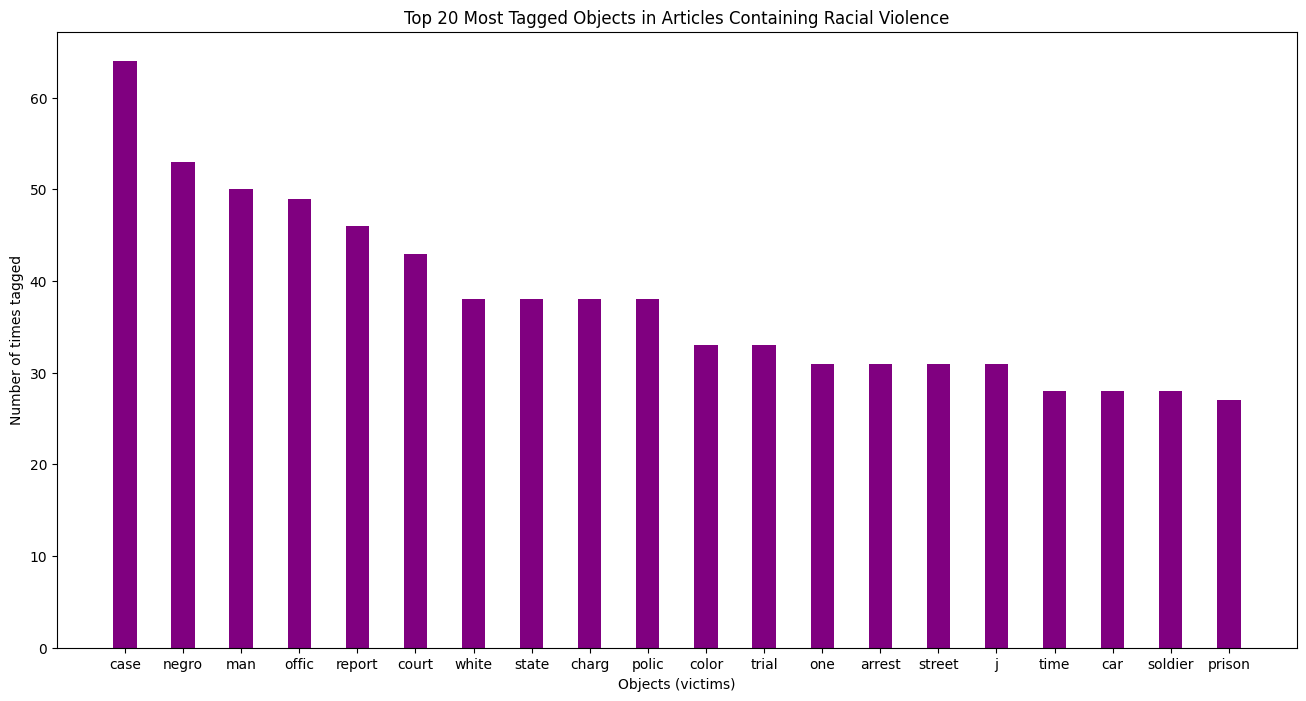

In [29]:
top_20_objects = pd.Series(at).value_counts().head(20)
values = top_20_objects.values
words = top_20_objects.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='purple',
		width = 0.4)

plt.xlabel("Objects (victims)")
plt.ylabel("Number of times tagged")
plt.title("Top 20 Most Tagged Objects in Articles Containing Racial Violence")
plt.show()

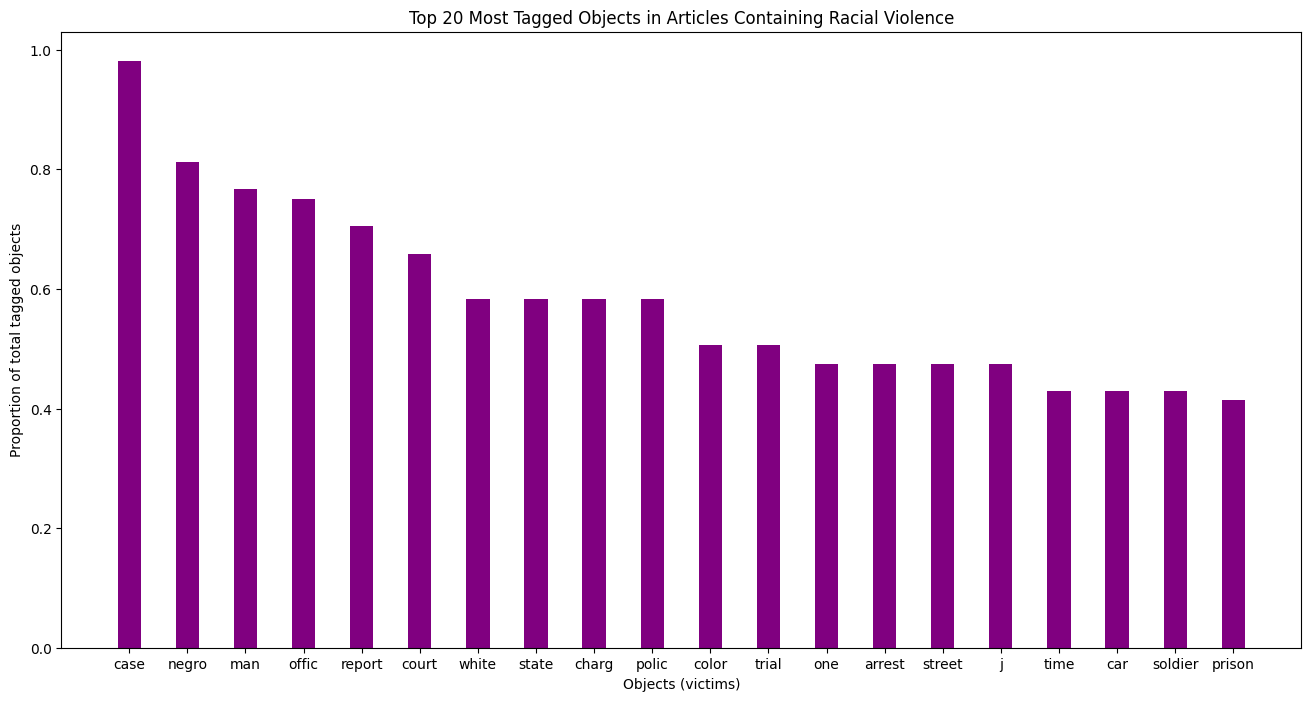

In [30]:
top_20_objects_prop = (pd.Series(at).value_counts().head(20)/sum(pd.Series(at).value_counts().values)) * 100
values = top_20_objects_prop.values
words = top_20_objects_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='purple',
		width = 0.4)

plt.xlabel("Objects (victims)")
plt.ylabel("Proportion of total tagged objects")
plt.title("Top 20 Most Tagged Objects in Articles Containing Racial Violence")
plt.show()

Verbs (actions)

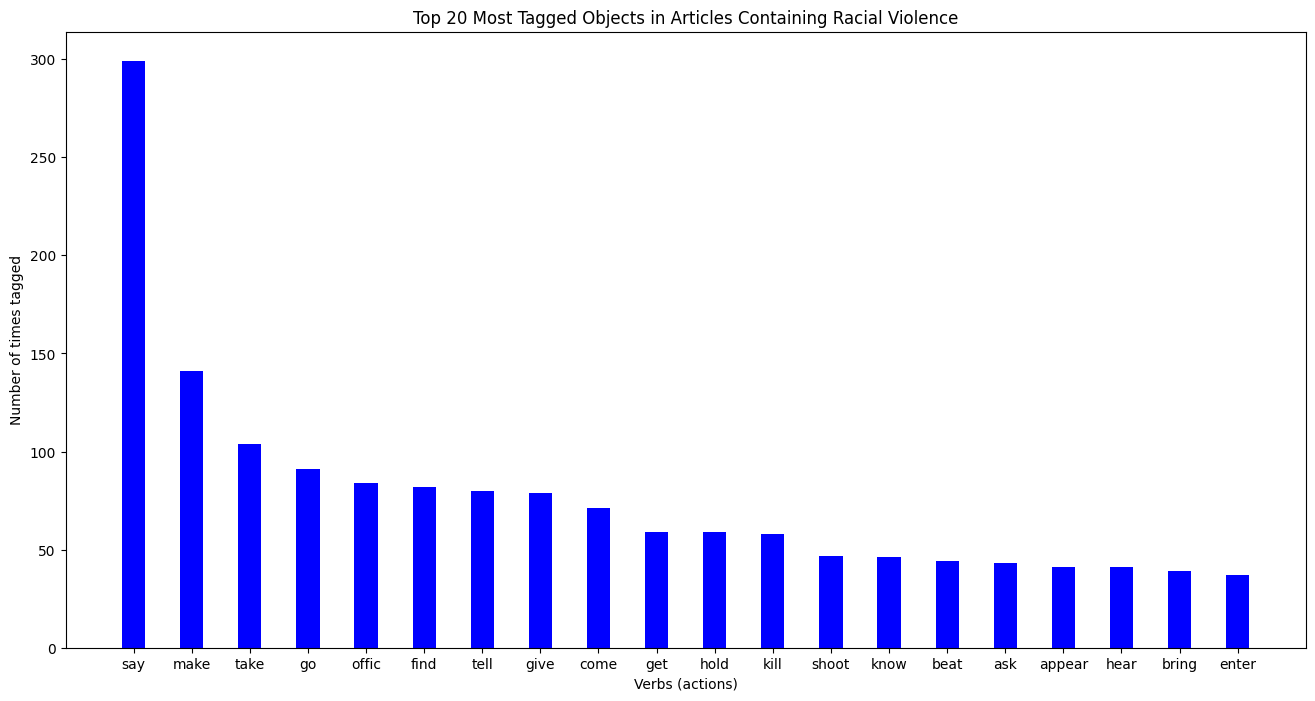

In [31]:
top_20_verbs = pd.Series(ve).value_counts().head(20)
values = top_20_verbs.values
words = top_20_verbs.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='blue',
		width = 0.4)

plt.xlabel("Verbs (actions)")
plt.ylabel("Number of times tagged")
plt.title("Top 20 Most Tagged Objects in Articles Containing Racial Violence")
plt.show()

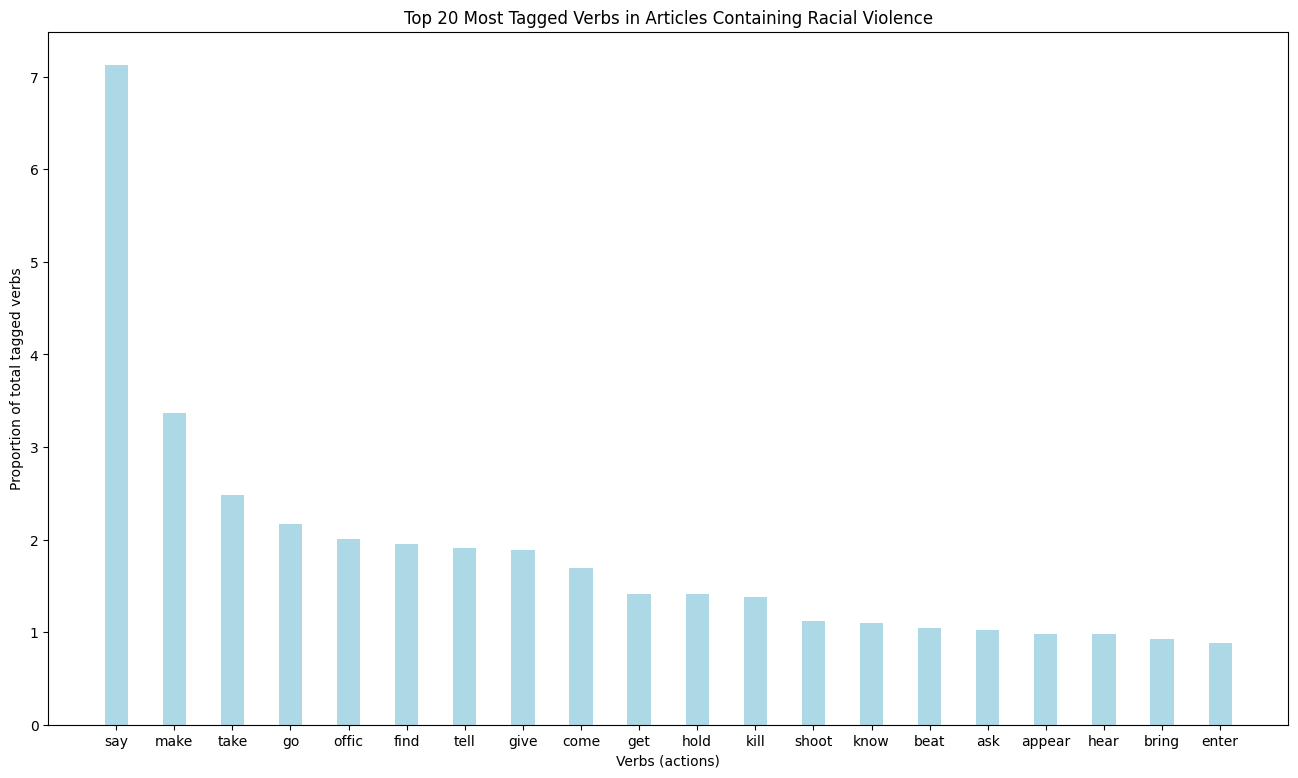

In [32]:
top_20_verbs_prop = (pd.Series(ve).value_counts().head(20)/sum(pd.Series(ve).value_counts().values)) * 100
values = top_20_verbs_prop.values
words = top_20_verbs_prop.index

fig = plt.figure(figsize = (16, 9))

plt.bar(words, values, color ='lightblue',
		width = 0.4)

plt.xlabel("Verbs (actions)")
plt.ylabel("Proportion of total tagged verbs")
plt.title("Top 20 Most Tagged Verbs in Articles Containing Racial Violence")
plt.show()

In [33]:
articles_nonviolence = articles[articles['entry'] == 0]

In [34]:
all_sub = []
all_at = []
all_ve = []
for i in range(len(articles_nonviolence)):
    doc = nlp(articles_nonviolence['text'].iloc[i])
    extract_svo(doc, all_sub, all_at, all_ve)

In [35]:
top_20_subjects_prop = (pd.Series(all_sub).value_counts().head(20)/sum(pd.Series(all_sub).value_counts().values)) * 100
all_values = top_20_subjects_prop.values
all_words = top_20_subjects_prop.index

Prop of subjects in all articles

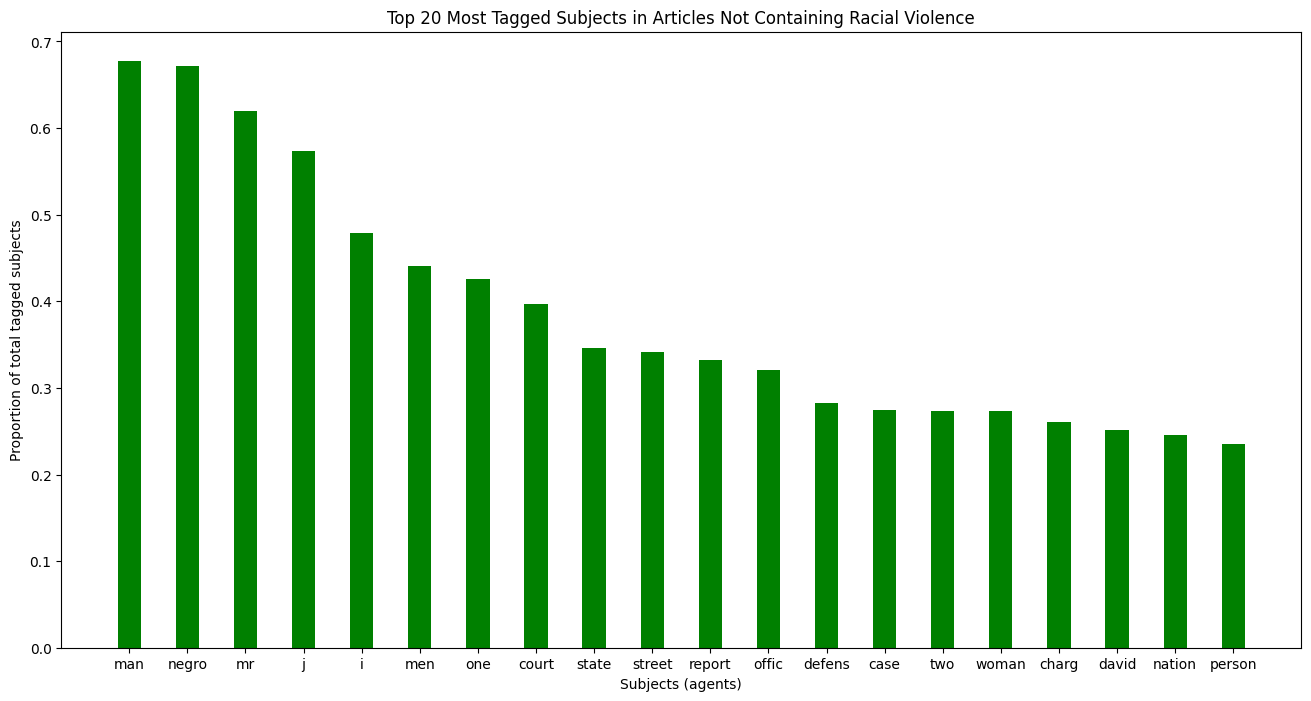

In [36]:
fig = plt.figure(figsize = (16, 8))

plt.bar(all_words, all_values, color ='green',
		width = 0.4)

plt.xlabel("Subjects (agents)")
plt.ylabel("Proportion of total tagged subjects")
plt.title("Top 20 Most Tagged Subjects in Articles Not Containing Racial Violence")
plt.show()

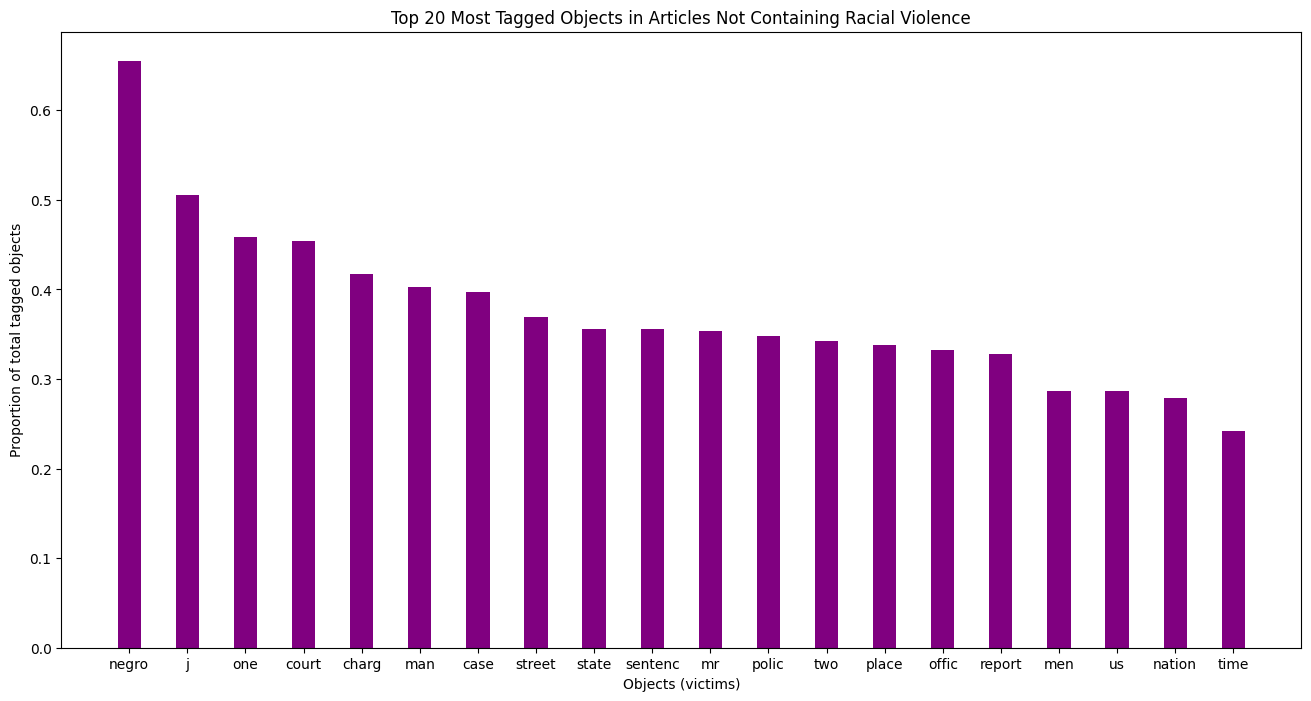

In [37]:
top_20_objects_prop = (pd.Series(all_at).value_counts().head(20)/sum(pd.Series(all_at).value_counts().values)) * 100
all_values = top_20_objects_prop.values
all_words = top_20_objects_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(all_words, all_values, color ='purple',
		width = 0.4)

plt.xlabel("Objects (victims)")
plt.ylabel("Proportion of total tagged objects")
plt.title("Top 20 Most Tagged Objects in Articles Not Containing Racial Violence")
plt.show()

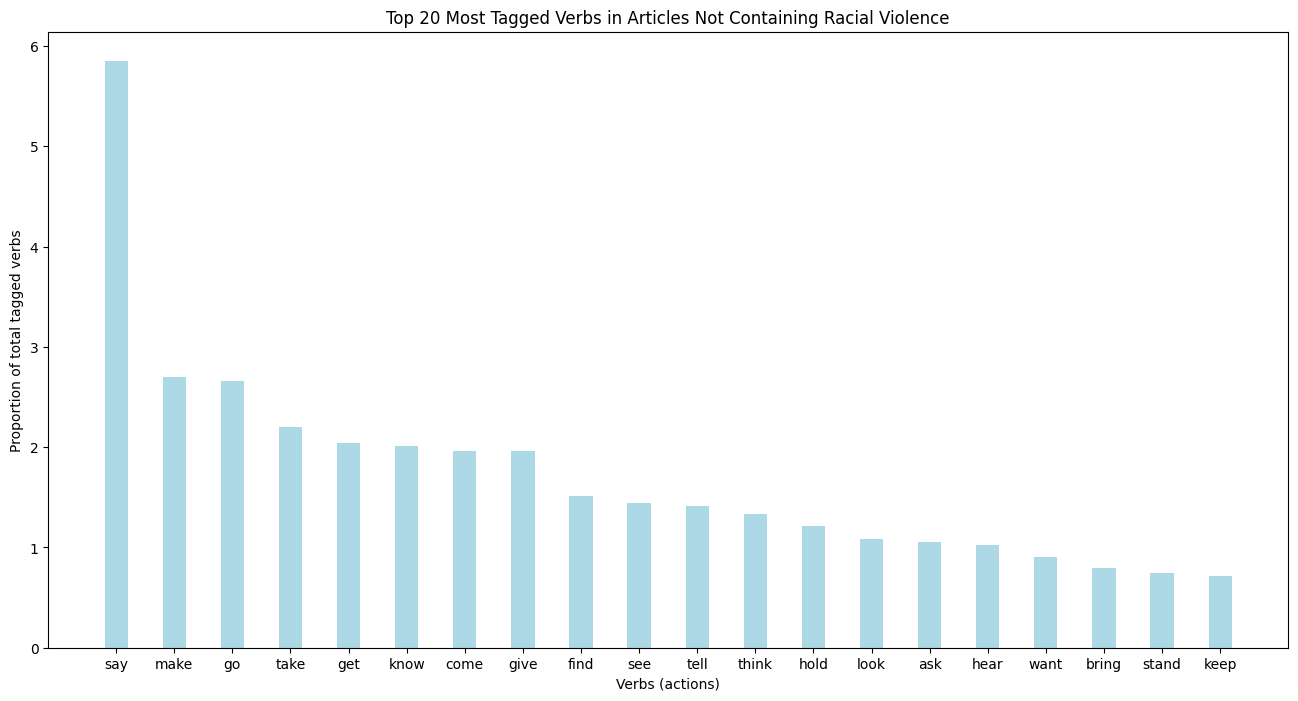

In [38]:
top_20_verbs_prop = (pd.Series(all_ve).value_counts().head(20)/sum(pd.Series(all_ve).value_counts().values)) * 100
all_values = top_20_verbs_prop.values
all_words = top_20_verbs_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(all_words, all_values, color ='lightblue',
		width = 0.4)

plt.xlabel("Verbs (actions)")
plt.ylabel("Proportion of total tagged verbs")
plt.title("Top 20 Most Tagged Verbs in Articles Not Containing Racial Violence")
plt.show()

Try a new method for cleaning text so SVO extraction can have more success (ideally/allegedly/hopefully)

In [39]:
articles_to_clean = pd.read_csv('/Users/clairefenton/Downloads/ATL_1941.csv')

In [40]:
keep = ['Article', 'Correspondence', 'Commentary', 'Front Page/Cover Story', 'Image/Photograph', 'Obituary', 'Review']

In [41]:
articles_to_clean = articles_to_clean[articles_to_clean['ObjectType'].isin(keep)]

In [42]:
import nltk
from nltk.corpus import stopwords

In [43]:
def text_preprocessing(text):
    text = text.lower()

    text = re.sub(r'[_"\-;%()|^+~&=*%.,!?:#$@\[\]/]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'xa0', '', text)
    text = re.sub(r'\\', '', text)
    text = re.sub(r'[\']', '', text)

    text = nltk.WordPunctTokenizer().tokenize(text)
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token) > 1]

    text = ' '.join(map(str, text))

    words = text.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]

    text = ' '.join(filtered_words)
    
    return text  

In [44]:
for i in range(len(articles_nonviolence)):
    doc = nlp(articles_nonviolence['text'].iloc[i])
    extract_svo(doc, all_sub, all_at, all_ve)

In [45]:
new_text = []
for i in range(len(articles_to_clean)):
    text = articles_to_clean['original_text'].iloc[i]
    text = text_preprocessing(text)
    new_text.append(text)

In [46]:
articles_to_clean.columns

Index(['Unnamed: 0', 'RecordID', 'AlphaPubDate', 'NumericPubDate',
       'original_text', 'text', 'ObjectType', 'StartPage'],
      dtype='object')

In [47]:
articles_to_clean['text'] = new_text

In [48]:
merged_articles = pd.merge(articles_to_clean, articles, on='RecordID', how='inner')

In [49]:
merged_violence = merged_articles[merged_articles['entry'] == 1]

Creating a function to make all three charts at once

In [50]:
aes_dict = {
    'sub' : {
        'index' : 0,
        'color' : 'green',
        'name' : 'Subjects'
    },
    'at' : {
        'index': 1,
        'color' : 'purple',
        'name' : 'Objects'
    },
    've' : {
        'index': 2,
        'color' : 'lightblue',
        'name' : 'Verbs'
    }
}

In [51]:
def clean_verbs(data):
    values = data.values
    words = data.index
    verb_counts = {}
    for i in range(len(words)):
        verb_counts[words[i]] = values[i]
    verbs_to_remove = ['say', 'make', 'take', 'go', 'tell', 'find', 'give', 'continue', 'come', 'get', 'ask', 'know', 'enter', 'hear', 'appear', 'set', 'put']
    for verb in verbs_to_remove:
        if verb in list(verb_counts.keys()):
            del verb_counts[verb]
    return pd.Series(data=verb_counts, index=list(verb_counts.keys()))

In [52]:
def create_hist(sov, publication, cutoff):
    for item in ['sub', 'at', 've']:
        top_prop = (pd.Series(sov[aes_dict[item]['index']]).value_counts()/sum(pd.Series(sov[aes_dict[item]['index']]).value_counts().values)) * 100
        if item == 've':
            top_prop = clean_verbs(top_prop)
        all_values = top_prop.values[:cutoff]
        all_words = top_prop.index[:cutoff]

        plt.figure(figsize = (16, 8))

        plt.bar(all_words, all_values, color = aes_dict[item]['color'],
                width = 0.4)

        plt.xlabel(aes_dict[item]['name'])
        plt.ylabel("Proportion of total tagged " + aes_dict[item]['name'].lower() + ' (%)')
        plt.title("Top 20 Most Tagged " + aes_dict[item]['name'] + " in Articles Containing Racial Violence " + "in " + publication)
        plt.show()

In [53]:
def hist_top_sov(df, text_col, publication):
    sub = []
    at = []
    ve = []
    for i in range(len(df)):
        doc = nlp(df[text_col].iloc[i])
        extract_svo(doc, sub, at, ve)
    create_hist([sub, at, ve], publication, 20)

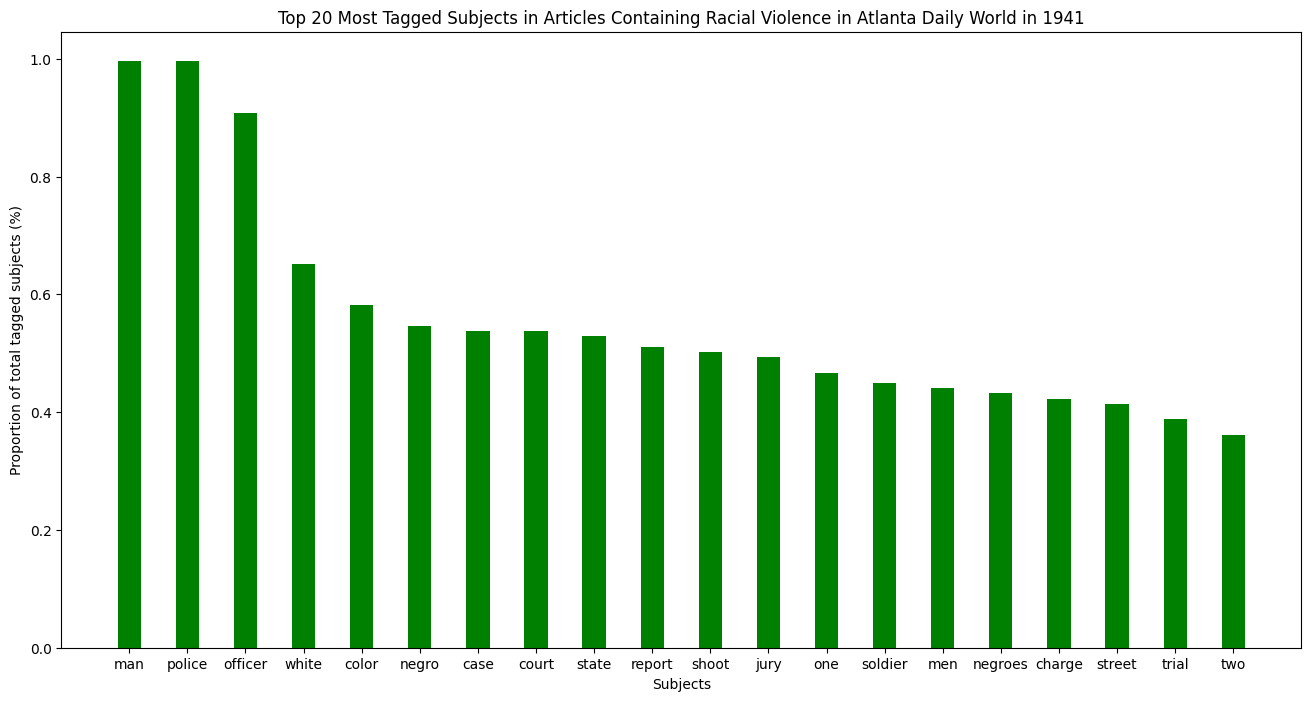

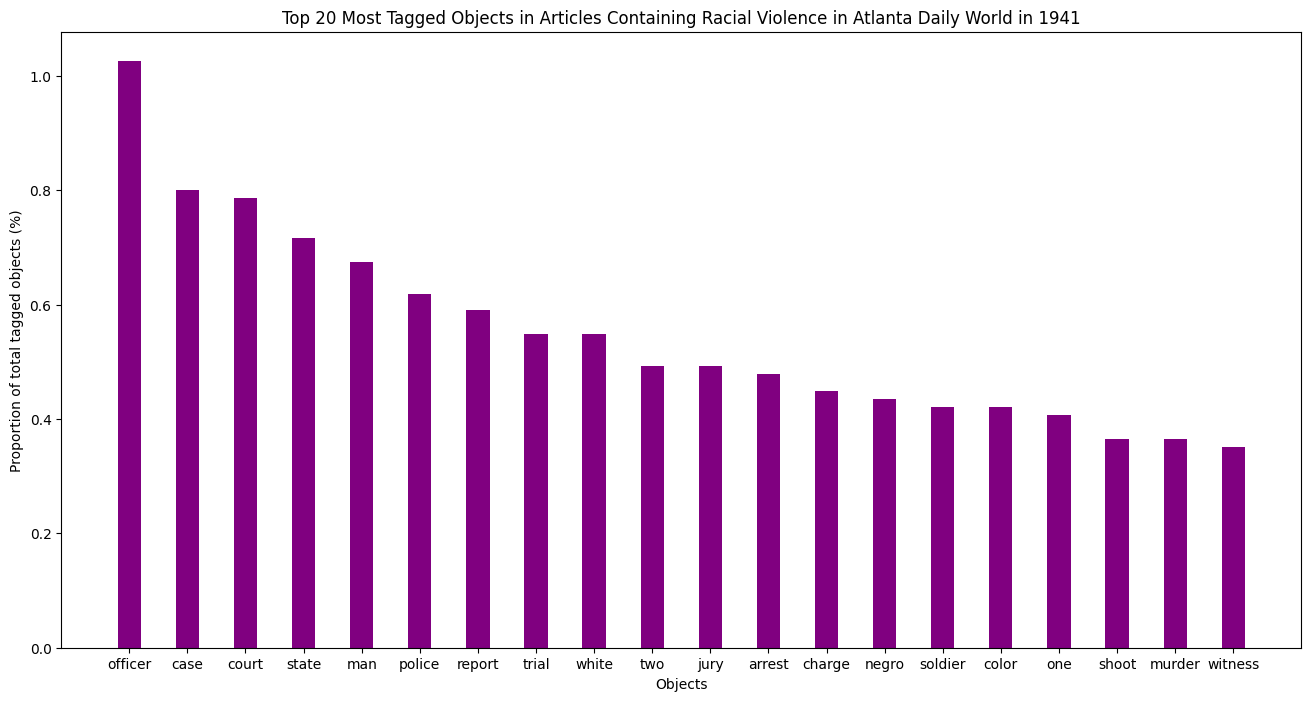

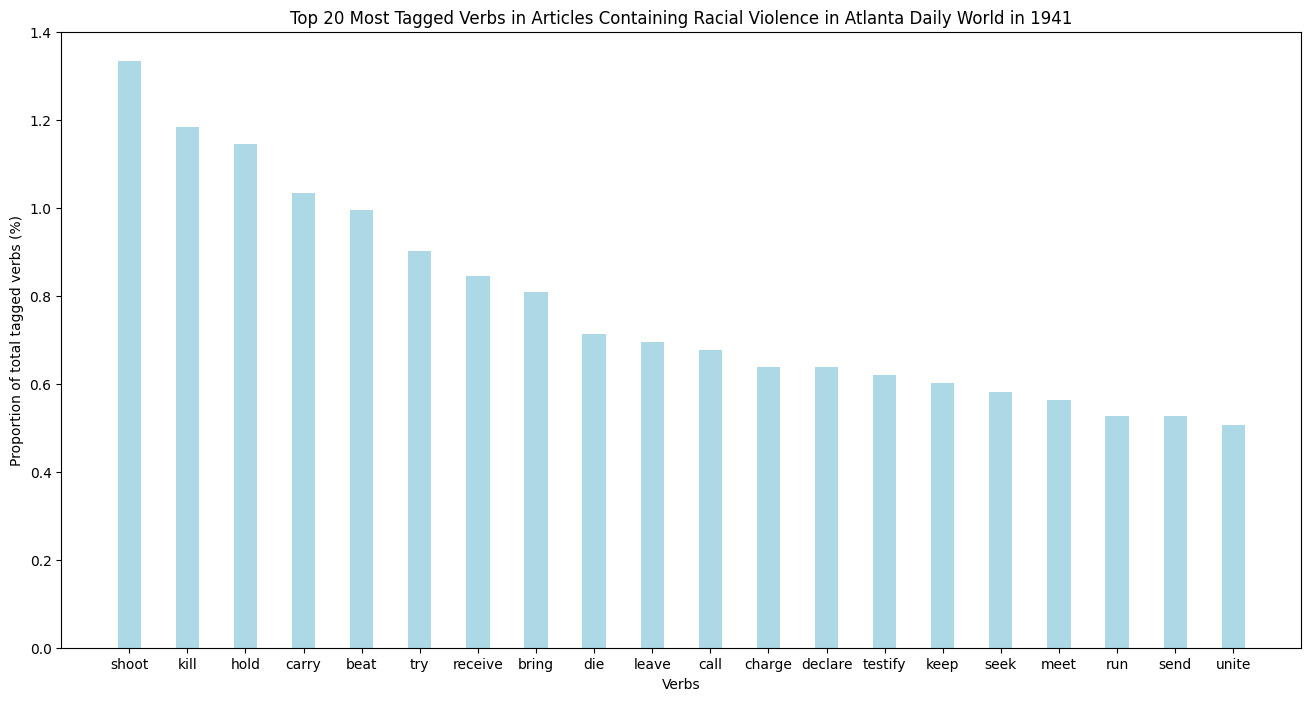

In [54]:
hist_top_sov(merged_violence, 'text_x', 'Atlanta Daily World in 1941')

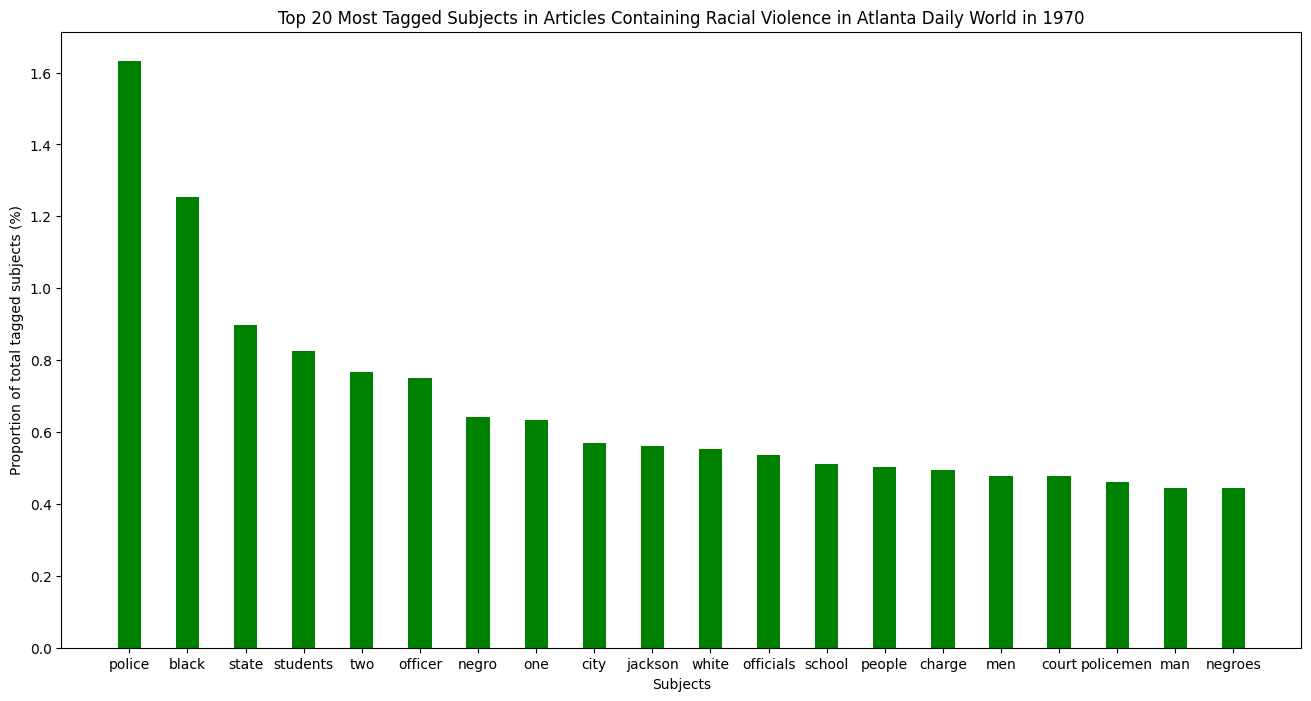

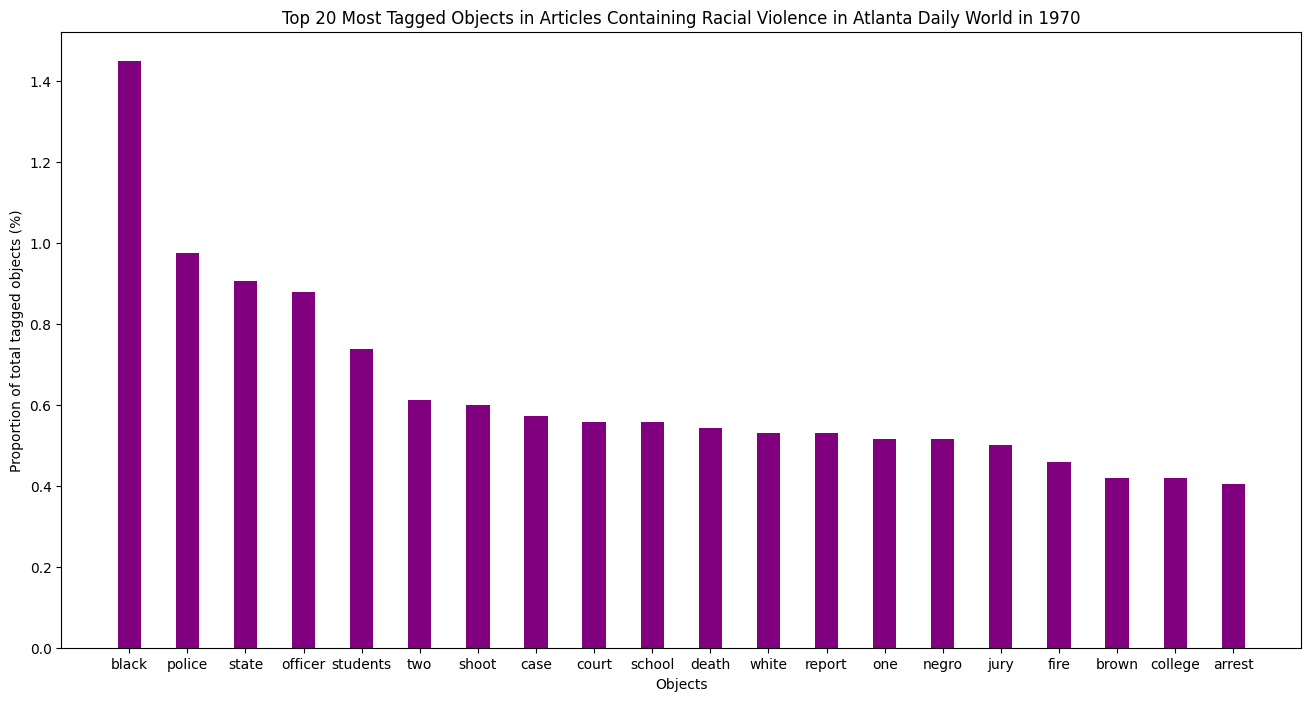

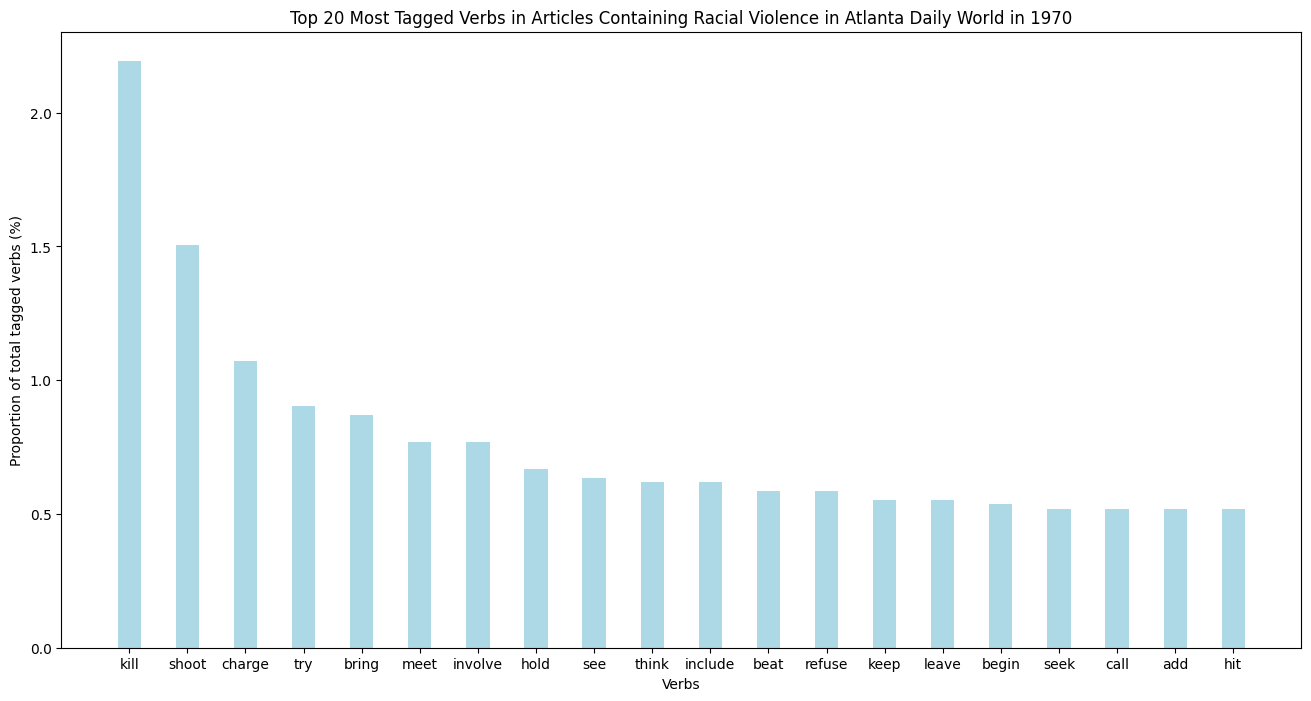

In [55]:
atl70_violence = atl70[atl70['CF_Correct'] == 1]
hist_top_sov(atl70_violence, 'text', 'Atlanta Daily World in 1970')

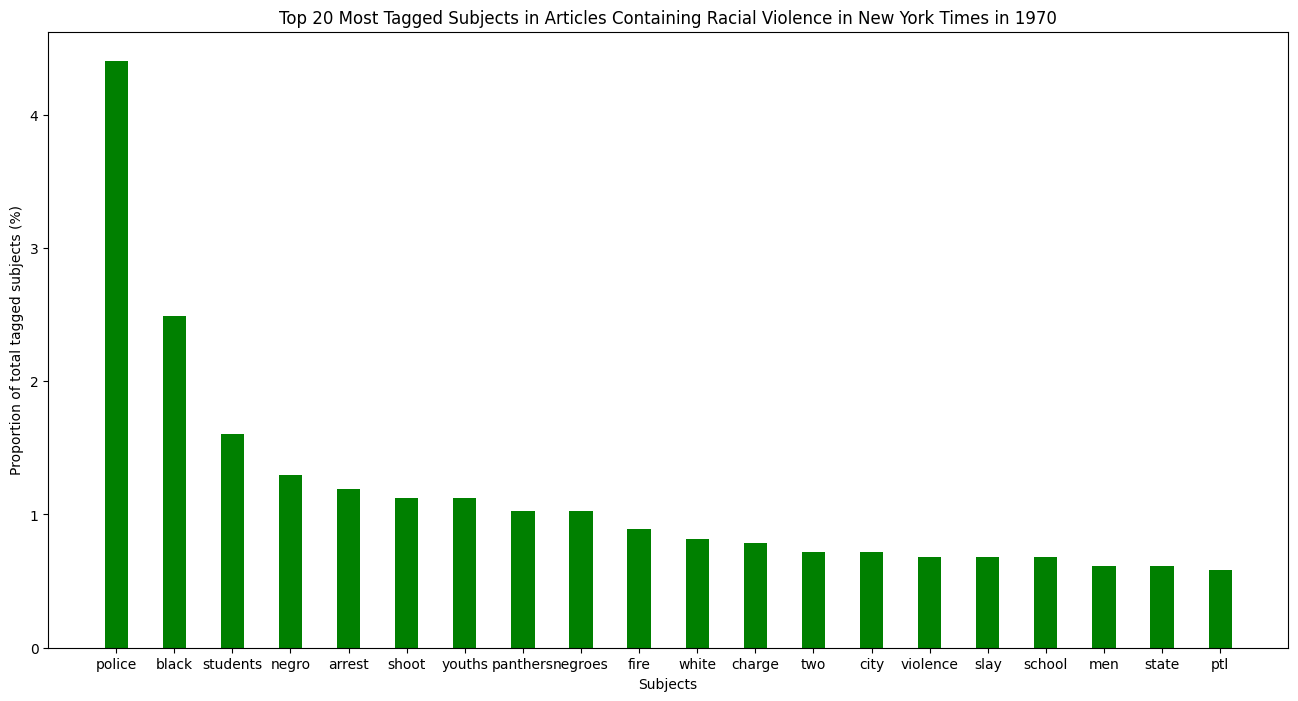

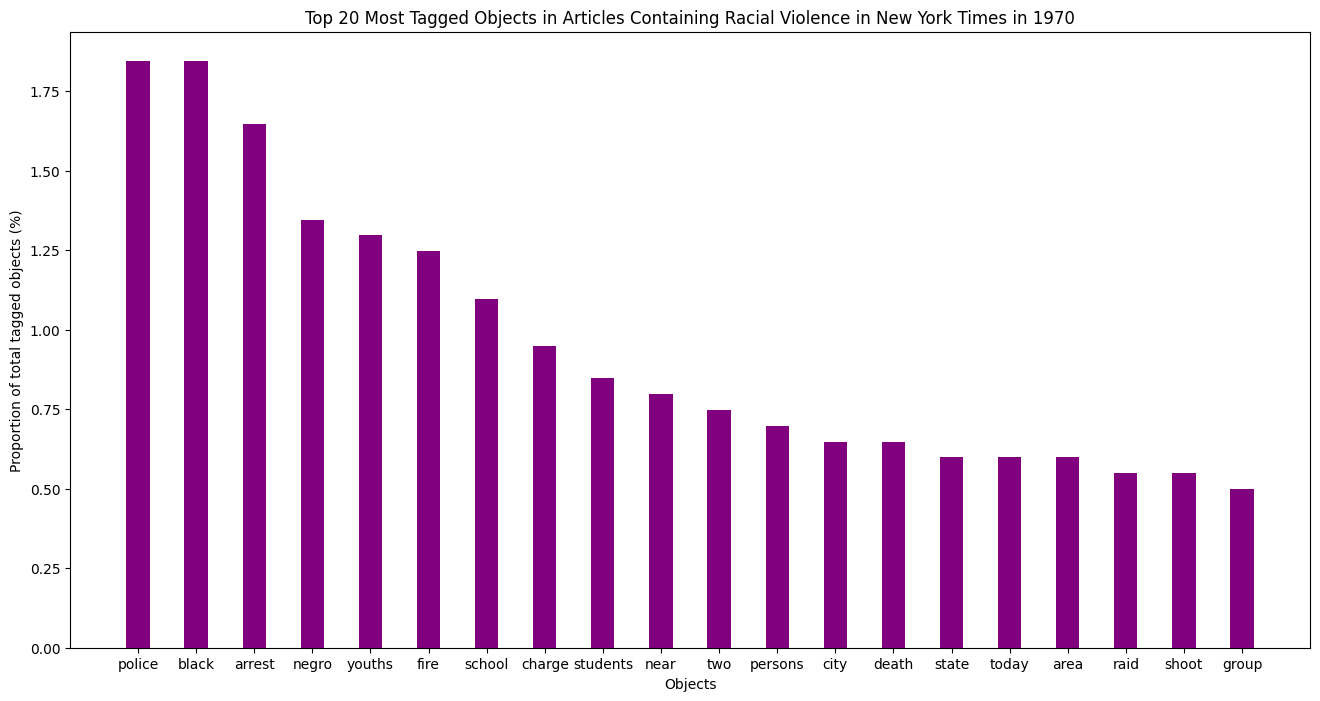

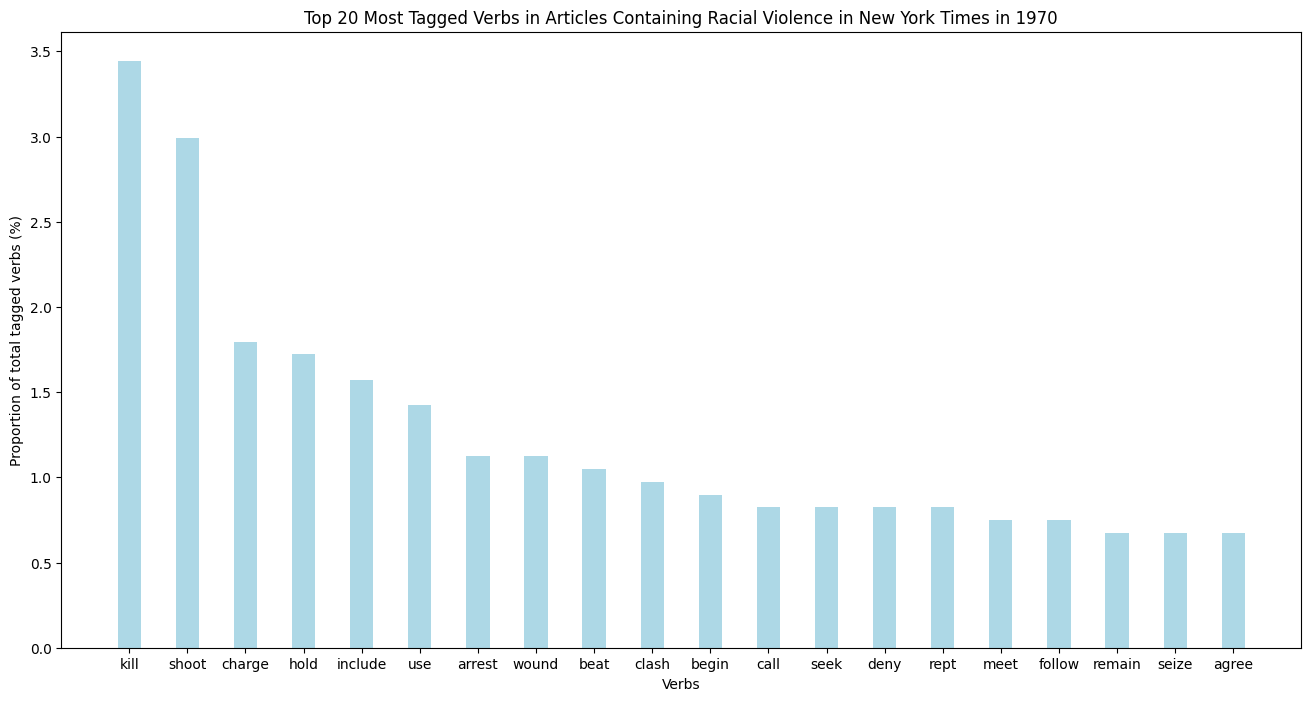

In [56]:
nyt_violence = nyt[nyt['Correct_KC'] == 1]
hist_top_sov(nyt_violence, 'text', 'New York Times in 1970')